In [1]:
import os
import pandas as pd
import cv2
from tqdm import tqdm
import numpy as np

In [2]:
# edit with your dataset path
root_path = "/kaggle/input/face-matching-aicc-round-2/face-matching"

# Dataset

In [3]:
import torch
from transformers import CLIPProcessor, CLIPModel
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(1234)

2026-02-06 11:27:56.338812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770377276.513806      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770377276.561933      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770377276.990308      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770377276.990348      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770377276.990351      55 computation_placer.cc:177] computation placer alr

In [4]:
ref_df = pd.read_csv(f"{root_path}/ref_img.csv", dtype={'ref_img': str})
ref_ids = ref_df["ref_img"].tolist()

img_dir = f"{root_path}/images"
all_images = os.listdir(img_dir)

# CLIP Model
We use clip to extract the embeddings of the image

In [5]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14", use_fast=True)
model.to(device)
model.eval()

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05,

In [6]:
from PIL import Image

In [7]:
features = {}
for img_id in tqdm(all_images):
    img_id = img_id.replace(".jpg","")
    img_path = f'{root_path}/images/{img_id}.jpg'
    img = Image.open(img_path).convert("RGB")

    with torch.no_grad():
        inputs = processor(images=img, return_tensors="pt").to(device)
        feature = model.get_image_features(**inputs)
        features[img_id] = feature.cpu().numpy()

100%|██████████| 109/109 [00:08<00:00, 13.43it/s]


# Clustering
To account for the variable number of images, we do clustering for the embeddings

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [9]:
key = np.array(list(features.keys()))
value = np.array(list(features.values())).squeeze(1)
value_scaled = StandardScaler().fit_transform(value)

In [10]:
tsne = TSNE(n_components=2, perplexity=50, random_state=1234)
emb = tsne.fit_transform(value_scaled)

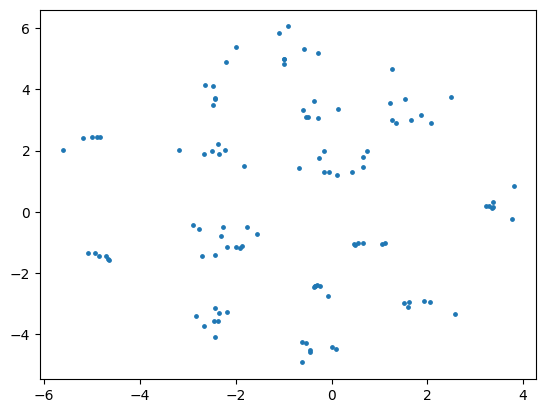

In [11]:
import matplotlib.pyplot as plt
plt.scatter(emb[:,0], emb[:,1],s=6)
plt.show()

In [86]:
kmean = KMeans(n_clusters=15, n_init=50)
lab = kmean.fit_predict(value_scaled)

ensure the size of cluster is at least 5

In [87]:
counts = np.bincount(lab)
counts

array([ 6,  8,  6,  7, 10,  7,  6, 12,  6,  6,  8,  5,  9,  7,  6])

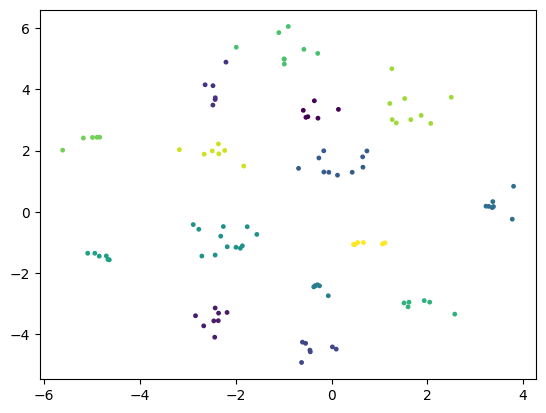

In [88]:
plt.scatter(emb[:,0], emb[:,1],c=lab, s=6)
plt.show()

# Submission

In [89]:
results = []

for ref_id in ref_ids:
    cluster_id = lab[np.where(key==ref_id)[0]]
    cluster_list = key[np.where(lab==cluster_id)]
    cluster_list = [x for x in cluster_list if x!=ref_id]
    results.append({"ref_img":ref_id,"photos":'|'.join(cluster_list)})

In [90]:
submission = pd.DataFrame(results)
submission

,ref_img,photos
0,048,066|101|078|102
1,025,033|094|067|006|042|086|005|041|032|083|040
2,095,014|047|072|021|045|097
3,043,034|027|100|023|013
4,105,029|024|002|001|057|093|050
5,071,049|011|017|088|070|065
6,046,069|010|075|019|060
7,096,018|068|015|098|035
8,020,038|031|077|091|053
9,085,106|036|103|037|009


In [91]:
submission.to_csv("submission.csv", index=False)